- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [32]:
from __future__ import print_function
#import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

In [31]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [50]:
classes=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [48]:
# установка параметров нейросети
batch_size = 32
num_classes = len(np.unique(train_labels))
epochs = 1
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_fashion_mnist_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

x_train shape: (60000, 28, 28)
60000 тренировочные примеры
10000 тестовые примеры


In [57]:
x_train.shape[1:]

(28, 28, 1)

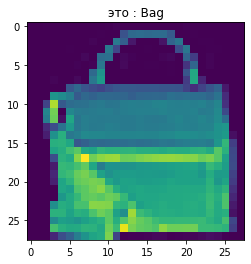

In [52]:
N = 1081

plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

In [58]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
1875/1875 [==============================] - 65s 34ms/step - loss: 0.9992 - accuracy: 0.6281 - val_loss: 0.6081 - val_accuracy: 0.7725
сохранить обученную модель как C:\Users\NitroPC\NeuralNet\lesson4\saved_models\keras_fashion_mnist_trained_model.h5 
313/313 [==============================] - 2s 6ms/step - loss: 0.6081 - accuracy: 0.7725
Test loss: 0.6081072688102722
Test accuracy: 0.7724999785423279


Две свёртки (32/64)

Точность на тесте - 0.772

In [59]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
1875/1875 [==============================] - 51s 27ms/step - loss: 1.6815 - accuracy: 0.3591 - val_loss: 0.8759 - val_accuracy: 0.6829
сохранить обученную модель как C:\Users\NitroPC\NeuralNet\lesson4\saved_models\keras_fashion_mnist_trained_model.h5 
313/313 [==============================] - 2s 4ms/step - loss: 0.8759 - accuracy: 0.6829
Test loss: 0.8759253025054932
Test accuracy: 0.6829000115394592


Три свёртки на том же общем числе нейронов (32/32/32)

Точность на тесте - 0.683

In [60]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
1875/1875 [==============================] - 125s 66ms/step - loss: 0.9648 - accuracy: 0.6417 - val_loss: 0.6092 - val_accuracy: 0.7703
сохранить обученную модель как C:\Users\NitroPC\NeuralNet\lesson4\saved_models\keras_fashion_mnist_trained_model.h5 
313/313 [==============================] - 4s 12ms/step - loss: 0.6092 - accuracy: 0.7703
Test loss: 0.6092448234558105
Test accuracy: 0.7702999711036682


Две свёртки, удвоенное количество нейронов (64/128)

Точность на тесте - 0.770

In [61]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
1875/1875 [==============================] - 64s 34ms/step - loss: 1.5934 - accuracy: 0.3898 - val_loss: 0.9018 - val_accuracy: 0.6324
сохранить обученную модель как C:\Users\NitroPC\NeuralNet\lesson4\saved_models\keras_fashion_mnist_trained_model.h5 
313/313 [==============================] - 2s 6ms/step - loss: 0.9018 - accuracy: 0.6324
Test loss: 0.9017945528030396
Test accuracy: 0.6323999762535095


Три свёртки, увеличенное количество нейронов (32/64/64)

Точность на тесте - 0.632 (на трейне точность почему-то 0.39)

Вывод: дополнительные конволюции запутывают сеть.

In [62]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
1875/1875 [==============================] - 65s 34ms/step - loss: 1.0473 - accuracy: 0.6056 - val_loss: 0.6465 - val_accuracy: 0.7641
сохранить обученную модель как C:\Users\NitroPC\NeuralNet\lesson4\saved_models\keras_fashion_mnist_trained_model.h5 
313/313 [==============================] - 2s 6ms/step - loss: 0.6465 - accuracy: 0.7641
Test loss: 0.6464608907699585
Test accuracy: 0.7641000151634216


In [ ]:
Две свёртки (32/64)
Два полносвязных слоя (512/512)

Точность на тесте - 0.764

In [63]:
# конфигурирование слоев нейросети
model = Sequential()

model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6925 - accuracy: 0.7677 - val_loss: 0.5153 - val_accuracy: 0.8222
сохранить обученную модель как C:\Users\NitroPC\NeuralNet\lesson4\saved_models\keras_fashion_mnist_trained_model.h5 
313/313 [==============================] - 1s 1ms/step - loss: 0.5153 - accuracy: 0.8222
Test loss: 0.5153064727783203
Test accuracy: 0.8222000002861023


Три полносвязных слоя (512/128/64)

Точность на тесте - 0.822

Вывод: возможно свёрткам просто не судьба. Но скорее всё-таки надо толком подбирать гиперпараметры конволюций, а не просто пихать в них новые слои и нейроны.